In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import signal
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(2)
torch.manual_seed(0)

# Load the datasets

In [2]:
X_train = np.load("./numpy_ds/x_train.npy")
X_val = np.load("./numpy_ds/x_val.npy")
X_test = np.load("./numpy_ds/x_test.npy")

y_train = np.load("./numpy_ds/y_train.npy")
y_val = np.load("./numpy_ds/y_val.npy")
y_test = np.load("./numpy_ds/y_test.npy")

In [70]:
class LSTMSpeechMode(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTMSpeechMode, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, 
                             batch_first=True, num_layers=1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        #seq_len = x.size(1)
        hidden = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        
        out, hidden = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [71]:
INPUT_SIZE = 13
HIDDEN_SIZE = 100
OUTPUT_SIZE = 3

In [84]:
random.seed(0)

def train_lstm(model, x_tr, y_tr, x_v, y_v, criterion, optimizer, epoch_range, batch_size):
    losses = []
    v_losses = []
   
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, x_tr.shape[0]), batch_size)
        x = np.zeros((batch_size, 299, 13))
        y = np.zeros((batch_size, 3))
        for i, feats in enumerate(selected):
            x[i, :, :] = x_tr[feats, :, :]
            y[i, :] = y_tr[feats, :]
        x = torch.from_numpy(x).float().cuda()
        y = torch.from_numpy(y).long().cuda()
        hidden = torch.randn(299, 2, batch_size, 8)
        #---------FORWARD------------#
        out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        out = out.view(batch_size, OUTPUT_SIZE)
        loss = criterion(out, torch.max(y,1)[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, x_v.shape[0]), 8)
        xv = np.zeros((8, 299, 13))
        yv = np.zeros((8, 3))
        for i, feats in enumerate(v):
            xv[i, :, :] = x_v[feats, :, :]
            yv[i, :] = y_v[feats, :]
        xv = torch.from_numpy(xv).float().cuda()
        yv = torch.from_numpy(yv).long().cuda()
        hidden_v = torch.randn(299, 8, 8)
        v_out = model.forward(xv)
        v_out = torch.tensor(v_out).float().cuda()
        v_out = v_out.view(8, 3)
        vloss = criterion(v_out, torch.max(yv, 1)[1])
        
        losses.append(loss.data[0])
        v_losses.append(vloss.data[0])
        if num_epoch%100= == 0:
            print('epoch [{}/{}], loss:{:.8f}, val:{:.8f}'.format(num_epoch, epoch_range, 
                                                              loss.data[0], vloss.data[0]))
    return losses, v_losses

In [85]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [89]:
epoch_range = 5000
batch_size = 48
learning_rate = 0.0001

lstm_1 = LSTMSpeechMode(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).cuda()
lstm_1.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    lstm_1.parameters(), lr=learning_rate)

losses_1, vloss = train_lstm(lstm_1, X_train, y_train, X_val, y_val,
                                 criterion, optimizer, epoch_range, batch_size)

/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/disk/scratch/s1769454/anaconda3/envs/dissertation/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [0/5000], loss:11.21879482, val:19.49786758
epoch [100/5000], loss:3.04476738, val:2.60097003
epoch [200/5000], loss:1.22547829, val:3.67819834
epoch [300/5000], loss:1.40868425, val:3.06870079
epoch [400/5000], loss:0.37615553, val:3.66526723
epoch [500/5000], loss:0.20707828, val:2.30409074
epoch [600/5000], loss:0.19675545, val:4.63812208
epoch [700/5000], loss:0.38427386, val:1.08940029
epoch [800/5000], loss:0.07128925, val:1.52805018
epoch [900/5000], loss:0.10038143, val:0.65481198
epoch [1000/5000], loss:0.03991289, val:2.83519268
epoch [1100/5000], loss:0.14652647, val:0.01094201
epoch [1200/5000], loss:0.13573645, val:0.61632466
epoch [1300/5000], loss:0.03073964, val:1.85349703
epoch [1400/5000], loss:0.03027841, val:1.75825489
epoch [1500/5000], loss:0.03582968, val:0.15828282
epoch [1600/5000], loss:0.01101366, val:2.79739547
epoch [1700/5000], loss:0.02185766, val:1.79950202
epoch [1800/5000], loss:0.01913408, val:0.78784084
epoch [1900/5000], loss:0.00982624, val:0

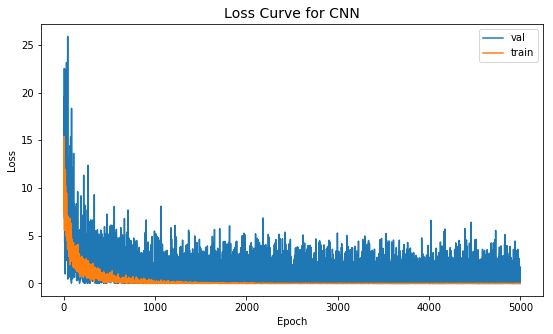

In [90]:
fig = plt.figure(figsize=(9, 5))
plt.title("Loss Curve for CNN", fontsize=14)
plt.plot(vloss, label="val")
plt.plot(losses_1, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig("./images/lstm_performance.pdf", bbox_inches='tight')

In [93]:
total = y_test.shape[0]
correct = 0

for i in range(X_test.shape[0]):
    data = X_test[i, :, :]
    data = torch.from_numpy(data).float().cuda()
    data = data.view(1, 299, 13)
    true_out = y_test[i, :]
    mdl_out = lstm_1.forward(data)
    mdl_out = mdl_out.view(1, 3)
    out = (mdl_out.data).cpu().numpy()
    if np.argmax(out) == np.argmax(true_out):
        correct += 1
print("Accuracy = ", correct*100/total)

Accuracy =  84.72222222222223
